<a href="https://colab.research.google.com/github/Nikelroid/DeepLearning_Project/blob/main/Phase-3/Phase3_Part2_debugged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://drive.google.com/file/d/1blGgEOlrHrM0-NAQxYVRwMlfiHDvVHXb/view
#!pip install --upgrade --no-cache-dir gdown
#!gdown --id "1blGgEOlrHrM0-NAQxYVRwMlfiHDvVHXb"

In [ ]:
#!unzip InstaNY100K

In [ ]:
#!pip install kaggle

In [ ]:
#import json 
#
#api = {"username":"a80abbasi","key":"c64917f1d1c750fbbeed83ac15b782e8"}
#with open('kaggle.json', 'w') as f:
#    json.dump(api, f)

In [ ]:
#!mkdir ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!kaggle datasets download -d hsankesara/flickr-image-dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!cp drive/MyDrive/flickr-image-dataset.zip /

In [ ]:
#!unzip flickr-image-dataset.zip

# Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

In [ ]:
from PIL import Image
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from torchvision import transforms

In [ ]:
df = pd.read_csv('./flickr30k_images/results.csv', delimiter='|')
df = df.dropna()
df.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# general config
MAX_LEN = 30

TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64

EPOCHS = 4
LEARNING_RATE = 5e-5

MODEL_NAME = 'bert-base-uncased'

In [ ]:
class MSCTD_Dataset (Dataset):
  def __init__(self, dataset_dir, images_dir, conversation_dir, texts, sentiments, transform=None):
    self.dataset_path = Path(dataset_dir)
    self.images_path = self.dataset_path / images_dir
    self.sentiment_path = self.dataset_path / sentiments
    self.text_path = self.dataset_path / texts
    self.conversations_path = self.dataset_path / conversation_dir

    self.transform = transform

    with open(self.text_path, 'r') as f:
        self.texts = f.read().splitlines()

    with open(self.sentiment_path, 'r') as f:
        self.sentiments = np.array(f.read().splitlines()).astype("int32")

    with open(self.conversations_path, 'r') as f:
        self.conversations = np.array(f.read().splitlines())
    
  def __len__(self):
        return len(self.sentiments)

  def __getitem__(self, idx):
        img_path = self.images_path / f'{idx}.jpg'
        image = Image.open(img_path)
        # image = read_image(str(img_path))
        if self.transform:
            image = self.transform(image)
       
        txt = self.texts[idx].strip()
        
        sentiment = self.sentiments[idx]

        data_dict = {"text":txt,
                     "image":image,
                     "sentiment":sentiment}
        return data_dict

In [ ]:
class Text_MSCTD(MSCTD_Dataset):
    def __init__(self, dataset_dir, conversation_dir, texts, sentiments,
                preprocess_func=None, pad_idx=None, max_len=None, transform=None, images_dir=''):
        super().__init__(dataset_dir, images_dir, conversation_dir, texts, sentiments, transform)
        self.preprocess_func = preprocess_func
        self.pad_idx = pad_idx
        self.max_len = max_len

    
    def __getitem__(self, idx):
        text = self.texts[idx]
        if self.preprocess_func is not None:
            text = self.preprocess_func(text)
            if self.max_len is not None:
                text = text[:self.max_len]
            if self.pad_idx is not None:
                text = F.pad(torch.tensor(text), (0, self.max_len - len(text)), 'constant', self.pad_idx)
        labels = self.sentiments[idx]
        return text, labels

In [ ]:
def bert_preprocess(text):
    return tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        padding='max_length',
        return_tensors='pt',
    )


train_dataset_text = Text_MSCTD('drive/MyDrive/dataset/train', 'image_index_train.txt', 'english_train.txt', 'sentiment_train.txt', preprocess_func=bert_preprocess)
dev_dataset_text = Text_MSCTD('drive/MyDrive/dataset/dev', 'image_index_dev.txt', 'english_dev.txt', 'sentiment_dev.txt', preprocess_func=bert_preprocess)
test_dataset_text = Text_MSCTD('drive/MyDrive/dataset/test', 'image_index_test.txt', 'english_test.txt', 'sentiment_test.txt' , preprocess_func=bert_preprocess)
train_loader_text = torch.utils.data.DataLoader(train_dataset_text, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
dev_loader_text = torch.utils.data.DataLoader(dev_dataset_text, batch_size=VALID_BATCH_SIZE, shuffle=False)
test_loader_text = torch.utils.data.DataLoader(test_dataset_text, batch_size=TEST_BATCH_SIZE, shuffle=False)

In [ ]:
class MultiModalDataset (Dataset):
  def __init__(self, dataset_dir, images_dir, texts, transform, preprocess_func=None, pad_idx=None, max_len=None):
    self.dataset_path = Path(dataset_dir)
    self.images_path = self.dataset_path / images_dir
    self.text_path = self.dataset_path / texts
    self.transform = transform

    self.preprocess_func = preprocess_func
    self.pad_idx = pad_idx
    self.max_len = max_len

    self.df = pd.read_csv(self.text_path, delimiter='|')
    self.df.columns = [col.strip() for col in self.df.columns]
    # shuffle
    self.df = self.df.sample(frac=1).reset_index()
    
  def __len__(self):
        return len(self.df)

  def __getitem__(self, idx):
        img_path = self.images_path / self.df.loc[idx, 'image_name']
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)
       
        text = self.df.loc[idx, 'comment']

        if self.preprocess_func is not None:
            text = self.preprocess_func(text)
            if self.max_len is not None:
                text = text[:self.max_len]
            if self.pad_idx is not None:
                text = F.pad(torch.tensor(text), (0, self.max_len - len(text)), 'constant', self.pad_idx)
        
        return image, text
     

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertConfig, BertTokenizer, BertForSequenceClassification
from torchvision import transforms

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
config = BertConfig.from_pretrained(MODEL_NAME)

In [ ]:
def bert_preprocess(text):
    # text = sent_preprocess(text)
    return tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        padding='max_length',
        return_tensors='pt',
    )
transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Resize((288,288),transforms.InterpolationMode("bicubic"))
                                ,transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])    

In [ ]:

dataset = MultiModalDataset('./flickr30k_images', 'flickr30k_images', 'results.csv',transform, preprocess_func=bert_preprocess)

In [ ]:
len(dataset)

158915

In [ ]:
img, text = dataset[43]
img

tensor([[[ 1.9043e+00,  1.8259e+00,  1.8604e+00,  ...,  4.0791e-01,
           1.7750e-01,  1.6765e-03],
         [ 1.8969e+00,  1.8619e+00,  1.8334e+00,  ...,  3.3306e-01,
           2.2362e-01, -9.2489e-03],
         [ 1.8762e+00,  1.8059e+00,  1.8583e+00,  ...,  2.9619e-01,
           1.7266e-01, -2.1515e-02],
         ...,
         [ 1.5173e+00,  1.2683e+00,  7.9840e-01,  ..., -6.2621e-01,
          -6.4593e-01, -6.6441e-01],
         [ 1.2687e+00,  3.4323e-01, -2.7090e-02,  ..., -7.1653e-01,
          -7.2369e-01, -6.9716e-01],
         [ 2.2270e-01,  2.2197e-02,  4.5332e-01,  ..., -7.6719e-01,
          -7.6347e-01, -7.4094e-01]],

        [[ 2.0902e+00,  2.0695e+00,  2.1014e+00,  ...,  7.2138e-01,
           5.2145e-01,  3.2993e-01],
         [ 2.0943e+00,  2.1055e+00,  2.0762e+00,  ...,  6.9935e-01,
           5.7169e-01,  3.1854e-01],
         [ 2.1234e+00,  2.0493e+00,  2.0864e+00,  ...,  7.1900e-01,
           5.1827e-01,  3.0891e-01],
         ...,
         [ 1.8016e+00,  1

## Processing Text

In [ ]:
!pip install pyenchant

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
import string
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

import enchant
english_dict = enchant.Dict("en_US")

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
!pip install emoji

import emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
NUM = '<NUM>'
UNK = '<UNK>'

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def sent_preprocess(sent, lower=True, remove_punct=True, remove_stopwords=False,
                    lemmatize=False, handle_nums=False, handle_unknowns=False, remove_emojies=True, join=True):
    if lower:
        sent = sent.lower()
    
    if remove_punct:
        sent = sent.translate(str.maketrans('', '', string.punctuation))

    if remove_emojies:
        sent = emoji.replace_emoji(sent)
    
    word_tokens = word_tokenize(sent)

    if remove_stopwords:
        word_tokens = [w for w in word_tokens if not w in stop_words]

    if lemmatize:
        word_tokens = [lemmatizer.lemmatize(w) for w in word_tokens]

    if handle_nums:
        
        def is_number(s):
            if s.isdigit():
                return True
            if s[:-2].isdigit():
                if s[-2:] == 'th' or s[-2:] == 'st' or s[-2:] == 'nd' or s[-2:] == 'rd':
                    return True
            return False

        word_tokens = [NUM if is_number(w) else w for w in word_tokens]

    if handle_unknowns:
        word_tokens = [w if english_dict.check(w) else UNK for w in word_tokens]

    if join:
        return ' '.join(word_tokens)

    return word_tokens

## Bert Config

In [ ]:
train_size = int(0.3 * len(dataset))
val_size = int(0.6 * len(dataset))
test_size = int(0.6 * len(dataset))
train_size, val_size, test_size

(47674, 95349, 95349)

In [ ]:
%cd ../..

/


In [ ]:
train_set, val_set, test_set, _ = torch.utils.data.random_split(dataset, [train_size, val_size, test_size, len(dataset) - train_size - val_size - test_size])
     

train_loader = DataLoader(train_set, batch_size=60, shuffle=True)
val_loader = DataLoader(val_set, batch_size=60, shuffle=False)
test_loader = DataLoader(test_set, batch_size=60, shuffle=False)

# Model

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !gdown 11caq-CNLP6_V3106zj0zAkFyYPAjyjyw
#!gdown 14Nh5c1pfzAuLF2nC3-IpugRi7eAMZvhW


from transformers import BertForSequenceClassification

def load_pretrained_bert(name='drive/MyDrive/models/bert_model.pt'):
    model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
        num_labels = 3,
        output_attentions = False,
        output_hidden_states = False,
    )
    model.load_state_dict(torch.load(name))
    return model

In [ ]:
class lastLayer(nn.Module):
    def __init__(self, pretrained):
        super(lastLayer, self).__init__()
        self.pretrained = pretrained
        self.last = nn.Sequential(
            nn.Dropout(p = 0.2,inplace=True),
            nn.Linear(1408, 90),
            nn.Dropout(p = 0.3,inplace=True),
            nn.Linear(90, 30),
            nn.Dropout(p = 0.1,inplace=True),
            nn.Linear(30, 3),
            )
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.last(x)
        return x

In [ ]:
#!gdown 1EfyDFNxAHGjvnLPRbP0SfnkV9g33-CFJ

from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

def load_pretrained_image(name ='drive/MyDrive/models/scene_modal_en.pth'):
    image_model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
    image_model.classifier = nn.Sequential()
    image_model = lastLayer(image_model)
    image_model.load_state_dict(torch.load(name))
    return image_model

# Training

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import tqdm

def one_epoch(models, loader, criterion, optimizer=None, epoch='', train=True, set_name='Train', metrics=None):
    tmp_accs = []
    total_loss = 0
    N = len(loader.dataset)
    Y = []
    Y_pred = []
    text_model, image_model = models
    text_model.eval()
    if train:
        image_model.train()
    else:
        image_model.eval()

    with torch.set_grad_enabled(train), tqdm.tqdm(enumerate(loader), total=len(loader)) as pbar:
        for i, data_i in pbar:
            if train:
                optimizer.zero_grad()
            image, text = data_i
            image = image.to(device)
            (input_ids, attention_mask, token_type_ids) = text.values()
            input_ids, attention_mask, token_type_ids = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device)
            input_ids = input_ids.squeeze(1)
            attention_mask = attention_mask.squeeze(1)
            token_type_ids = token_type_ids.squeeze(1)
            
            output = text_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            p_text = output.logits
            p_image = image_model(image)
            y_pred = p_image.argmax(dim=-1)
            y_true = p_text.argmax(dim=-1)
            loss = criterion(p_text, p_image, y_true)
            tmp_accs.append(np.count_nonzero(y_pred.cpu()==y_true.cpu()) / len(y_true.cpu()))
            total_loss += loss.item() * len(image)
            pbar.set_description(f'{epoch}: {set_name} Loss: {total_loss / (i+1):.3e} - Accuracy: {sum(tmp_accs)*100/len(tmp_accs):.2f}%')
            if train:
                loss.backward()
                optimizer.step()

            Y.append(y_true.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())

    total_loss /= N

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy_score(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    result = {'loss': total_loss, 'accuracy': acc}
    if metrics is not None:
        result.update({metric: metric_func(Y, Y_pred) for metric, metric_func in metrics.items()})

    return result

In [ ]:
def train_model(models, dataloaders, num_epochs, criterion, optimizer, model_name='pytroch-model', scheduler=None):
    train_loader, val_loader = dataloaders
    min_val_loss = np.inf
    min_val_acc = 0

    text_model, image_model = models

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        result = one_epoch(models, train_loader, criterion, optimizer, epoch, train=True, set_name='Train')
        train_loss = result['loss']
        train_acc = result['accuracy']
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_result = one_epoch(models, val_loader, criterion, epoch=epoch, train=False, set_name='Validation')
        val_loss = val_result['loss']
        val_acc = val_result['accuracy']
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print('\n', '-' * 60)

        if val_acc > max_val_acc:
            max_val_acc = val_acc
            torch.save(image_model.state_dict(), f'{model_name}.pt')

        if val_loss < min_val_loss:
            min_val_loss = val_loss


        if scheduler:
            scheduler.step(val_loss)

    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title('loss history of training and val sets')
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label='train')
    plt.plot(val_accuracies, label='val')
    plt.title('Accuracy history of training and val sets')
    plt.legend()
    plt.show()

    image_model.load_state_dict(torch.load(f'{model_name}.pt'))
    return image_model, min_val_loss

In [ ]:
import tqdm

def retrain(model, loader, criterion, optimizer=None, epoch='', train=True, model_name='bert', set_name='Train', metrics=None):
    total_loss = 0
    N = len(loader.dataset)
    Y = []
    Y_pred = []
    model.train()
    tmp_accs = []
    with torch.set_grad_enabled(train), tqdm.tqdm(enumerate(loader), total=len(loader)) as pbar:
        for i, data_i in pbar:
            optimizer.zero_grad()
            data_i, y = data_i
            (input_ids, attention_mask, token_type_ids) = data_i.values()
            input_ids, attention_mask, token_type_ids = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device)
            y = y.long().to(device)
            input_ids = input_ids.squeeze(1)
            attention_mask = attention_mask.squeeze(1)
            token_type_ids = token_type_ids.squeeze(1)
            
            output = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=y)
            loss = output.loss
            
            total_loss += loss.item() * len(input_ids)
            
            loss.backward()
            optimizer.step()

            y_pred = output.logits.argmax(dim=-1)
            
            Y.append(y.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())
            tmp_accs.append(np.count_nonzero(y_pred.cpu()==y.cpu()) / len(y.cpu()))
            pbar.set_description(f'{epoch}: {set_name} Loss: {total_loss / (i+1):.3e} - Accuracy: {sum(tmp_accs)*100/len(tmp_accs):.2f}%')
    total_loss /= N

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy_score(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    result = {'loss': total_loss, 'accuracy': acc}
    if metrics is not None:
        result.update({metric: metric_func(Y, Y_pred) for metric, metric_func in metrics.items()})

    return result

In [ ]:
class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.9, T=2):
        super().__init__()
        self.alpha = alpha
        self.T = T
        self.kl_div = nn.KLDivLoss(log_target=True, reduction="batchmean")
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, p_true, p_pred, y_true):
        logit_loss = self.kl_div(F.log_softmax(p_pred / self.T, dim=-1), F.log_softmax(p_true / self.T, dim=-1)) 
        label_loss = self.cross_entropy(p_pred, y_true)
        return (1-self.alpha) * label_loss + self.alpha * self.T * self.T * logit_loss

In [ ]:
%cd content

/content


In [ ]:
text_model = load_pretrained_bert()
text_model = text_model.to(device)
text_model.requires_grad_(False)
text_model.eval()

image_model = load_pretrained_image()
image_model = image_model.to(device)
image_model.eval()

In [ ]:
# Training Configuration
LEARNING_RATE = 1e-4
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, image_model.parameters()), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, verbose=True, factor=0.5)
criterion = DistillationLoss(alpha=0.5)

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Sun Feb 12 05:57:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    32W /  70W |   1284MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

average_policy = 'macro'
metrics = {'accuracy': accuracy_score, 'precision': lambda y1, y2: precision_score(y1, y2, average=average_policy),
           'recall': lambda y1, y2: recall_score(y1, y2, average=average_policy),
           'f1': lambda y1, y2: f1_score(y1, y2, average=average_policy),
           'confusion_matrix': confusion_matrix}

In [ ]:
def eval_model(models, loader, metrics=metrics, set_name='Test', plot_confusion_matrix=True):
    results = one_epoch(models, loader, criterion, train=False, set_name=set_name, metrics=metrics)
    disp = ConfusionMatrixDisplay(results.pop('confusion_matrix'))
    if plot_confusion_matrix:
        disp.plot()
    return results

### Before training:

: Test Loss: 2.086e+01 - Accuracy: 29.66%: 100%|██████████| 497/497 [05:01<00:00,  1.65it/s]

Accuracy of Test set: 0.29669015857034986


{'loss': 0.6524287383321729,
 'accuracy': 0.29669015857034986,
 'precision': 0.35245478034579286,
 'recall': 0.3593990727967067,
 'f1': 0.2599917007854025}

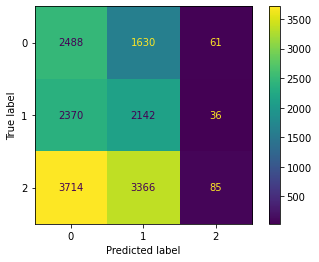

In [ ]:
eval_model((text_model, image_model), test_loader)

In [ ]:
LEARNING_RATE = 1e-4
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, image_model.parameters()), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, verbose=True, factor=0.5)
criterion = DistillationLoss(alpha=0.5)

In [ ]:
EPOCH = 10
image_model, min_val_loss = train_model((text_model, image_model), (train_loader, val_loader), EPOCH, criterion, optimizer, model_name='weakly_sup', scheduler=scheduler)

0: Train Loss: 3.502e+01 - Accuracy: 47.65%: 100%|██████████| 795/795 [21:02<00:00,  1.59s/it]


Accuracy of Train set: 0.47648613500020975


0: Validation Loss: 3.465e+01 - Accuracy: 48.34%:  24%|██▍       | 389/1590 [06:42<20:43,  1.04s/it]


KeyboardInterrupt: ignored

In [ ]:
!ls

drive  flickr30k_images  flickr-image-dataset.zip  kaggle.json	sample_data


In [ ]:
%cd models

/content/drive/.shortcut-targets-by-id/1_9oDyIAaO6cmT08TeUA0pmrbpLYryxsJ/models


In [ ]:
torch.save(image_model.state_dict(), 'weak_sup.pt')

RuntimeError: ignored

In [ ]:
eval_model((text_model, image_model), test_loader)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd content/drive/MyDrive
torch.save(text_model.state_dict(), 'models/bert_model_weak_sup.pt')
torch.save(image_model.state_dict(), 'models/scene_model_weak_sup.pt')